# Procesamiento Adaptativo de Señales Aleatorias
# Trabajo Práctico N°1 - Estimación espectral no-paramétrica
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

## TODO
* Agregar la otra zona de ruido
* Agregar %%time a todo
* Verificar labels de ejes en gráficos ('GPS time'), algunos faltantes
* Shift en frecuencia
* Estacionareidad

In [1]:
import h5py
import numpy as np
import scipy.signal as sps
import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
def read_ligo(filename):
    f = h5py.File(filename, 'r')
    strain = f['strain/Strain'][...]
    fs = 1/ f['strain/Strain'].attrs['Xspacing']
    start_time = f['meta/GPSstart'][()]
    f.close()
    return strain, start_time, fs

In [3]:
# Open hdf5 files
h1_s, h1_st, h1_fs = read_ligo('../assets/data/h1_32sec_4khz.hdf5')
l1_s, l1_st, l1_fs = read_ligo('../assets/data/l1_32sec_4khz.hdf5')

In [4]:
event_start_gps = 1126259462.442
event_start = event_start_gps - h1_st
event_delta = 0.2
time = np.arange(0,h1_s.shape[0]/h1_fs, 1/h1_fs)

In [5]:
# Substract mean to signals
h1_s -= np.mean(h1_s)
l1_s -= np.mean(l1_s)

In [6]:
from helpers.check_stationarity import check_stationarity
from statsmodels.tsa.stattools import adfuller, kpss

## Estacionariedad
A continuación se realizará una prueba de estacionariedad sobre las señales con las que se trabaja. Un análisis sobre los distintos métodos y distintas formas de comprobar la estacionariedad de una serie se encuentran desarrollados en el archivo stationary_test.ipynb.

### Prueba Dickey-Fuller Aumentada

In [7]:
t_stat, p_value, _, _, critical_values, _ = adfuller(h1_s[0:int(len(h1_s))])
check_stationarity(p_value=p_value)

print(f'adfuller Statistic: {t_stat}')
print(f'p-value: {p_value}')
print('Critial Values:')
for key, value in critical_values.items():
    print(f'   {key} : {value}')
print(f'Result: The series is {"not " if p_value > 0.05 else ""}stationary')

p-value: 0.96
p-threshold: 0.05
=> Serie No Estacionaria
adfuller Statistic: -0.008350747602001642
p-value: 0.9578360124698427
Critial Values:
   1% : -3.430399892257422
   5% : -2.8615620516537255
   10% : -2.566781737313602
Result: The series is not stationary


### Prueba KPSS

In [8]:
t_stat, p_value, _, critical_values = kpss(h1_s, nlags='auto')
check_stationarity(p_value=p_value, type='kpss')


print(f'KPSS Statistic: {t_stat}')
print(f'p-value: {p_value}')
print('Critial Values:')
for key, value in critical_values.items():
    print(f'   {key} : {value}')
print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

p-value: 0.10
p-threshold: 0.05
=> Serie Estacionaria
KPSS Statistic: 0.015029731693863707
p-value: 0.1
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


c:\python38\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


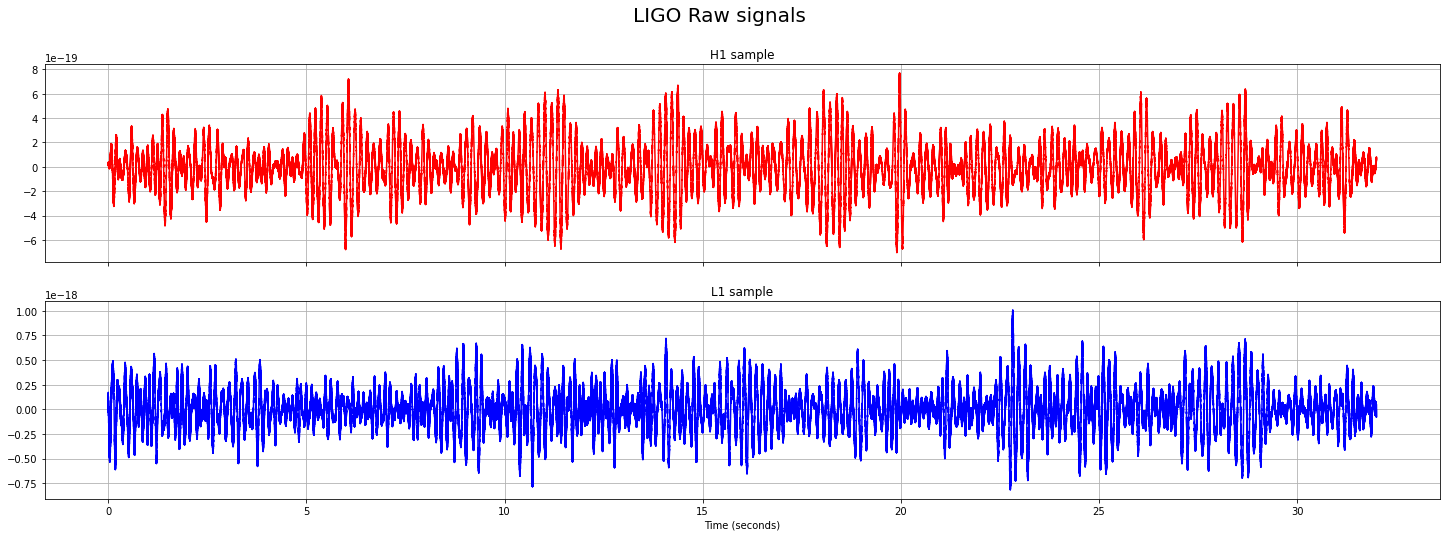

In [9]:
# Plot raw signals
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Raw signals', fontsize=20)
axs[0].plot(time, h1_s, color='red')
axs[1].plot(time, l1_s, color='blue')
axs[0].set_title('H1 sample')
axs[1].set_title('L1 sample')
axs[1].set_xlabel('Time (seconds)')
axs[0].grid()
axs[1].grid()

In [10]:
# Using a 4 second window to ensure catching events in both sites
h1_event = h1_s[(time >= event_start-2) & (time <= event_start + 2)]
l1_event = l1_s[(time >= event_start-2) & (time <= event_start + 2)]
time_event = time[(time >= event_start-2) & (time <= event_start + 2)]

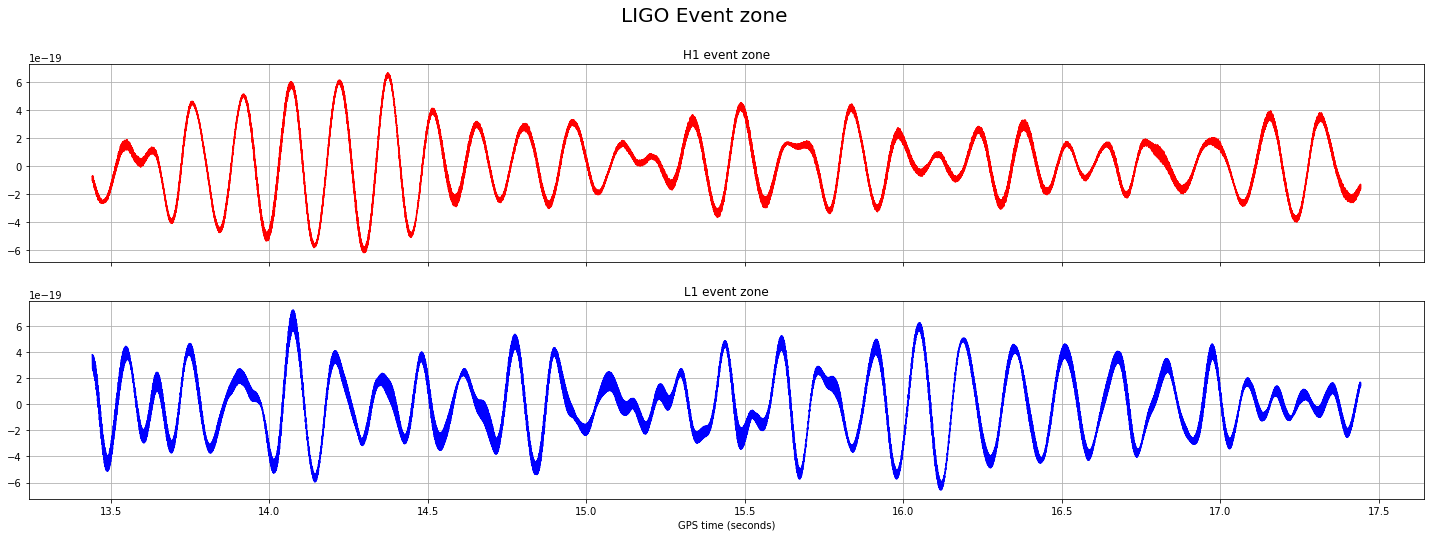

In [11]:
# Plot raw events
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Event zone',fontsize=20)
axs[0].plot(time_event, h1_event, color='red')
axs[1].plot(time_event, l1_event, color='blue')
axs[0].set_title('H1 event zone')
axs[1].set_title('L1 event zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

In [12]:
# Get silence (noise)
h1_silence = h1_s[(time > event_start + 2)]
l1_silence = l1_s[(time > event_start + 2)]
time_silence = time[(time > event_start + 2)]

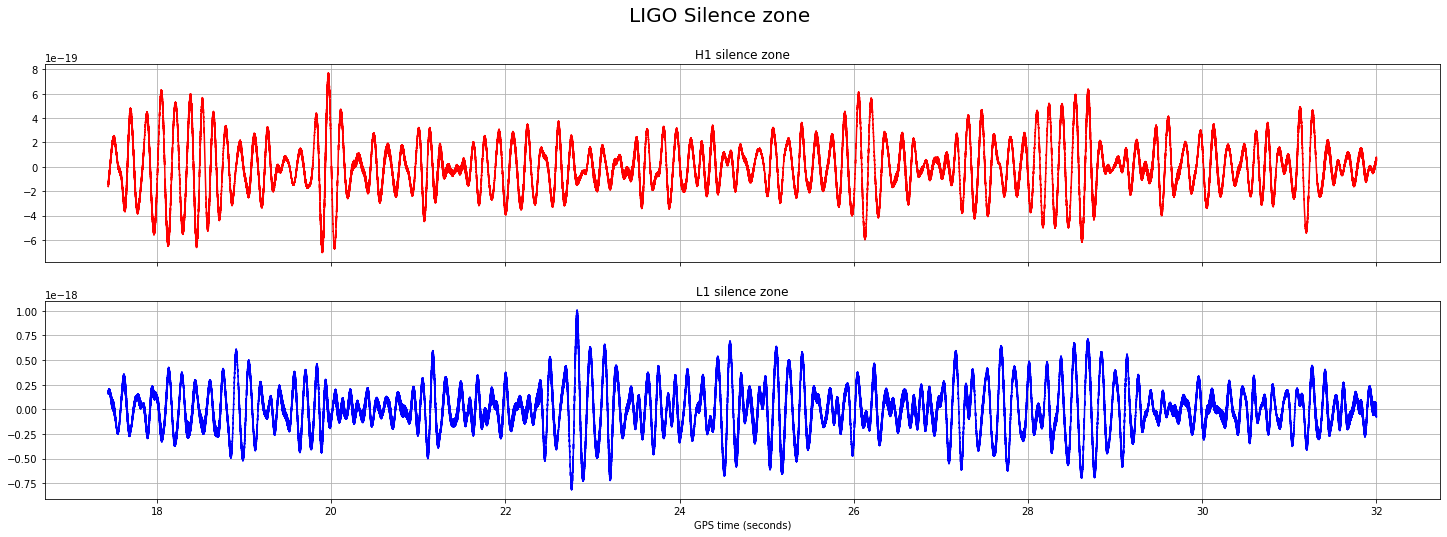

In [13]:
# Plot raw events
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Silence zone',fontsize=20)
axs[0].plot(time_silence, h1_silence, color='red')
axs[1].plot(time_silence, l1_silence, color='blue')
axs[0].set_title('H1 silence zone')
axs[1].set_title('L1 silence zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

# Estimating noise psd

In [14]:
from helpers.periodogram import periodogram
from helpers.per_averaging import periodogram_averaging
from helpers.per_smoothing import periodogram_smoothing

## Periodogram

In [15]:
def plot_periodogram(ax, fs, signal, window):
    f, per = periodogram(signal, window=window)
    f *= fs
    ax.loglog(f,per, label=window)
    ax.grid(axis='both', which='both')

Wall time: 349 ms


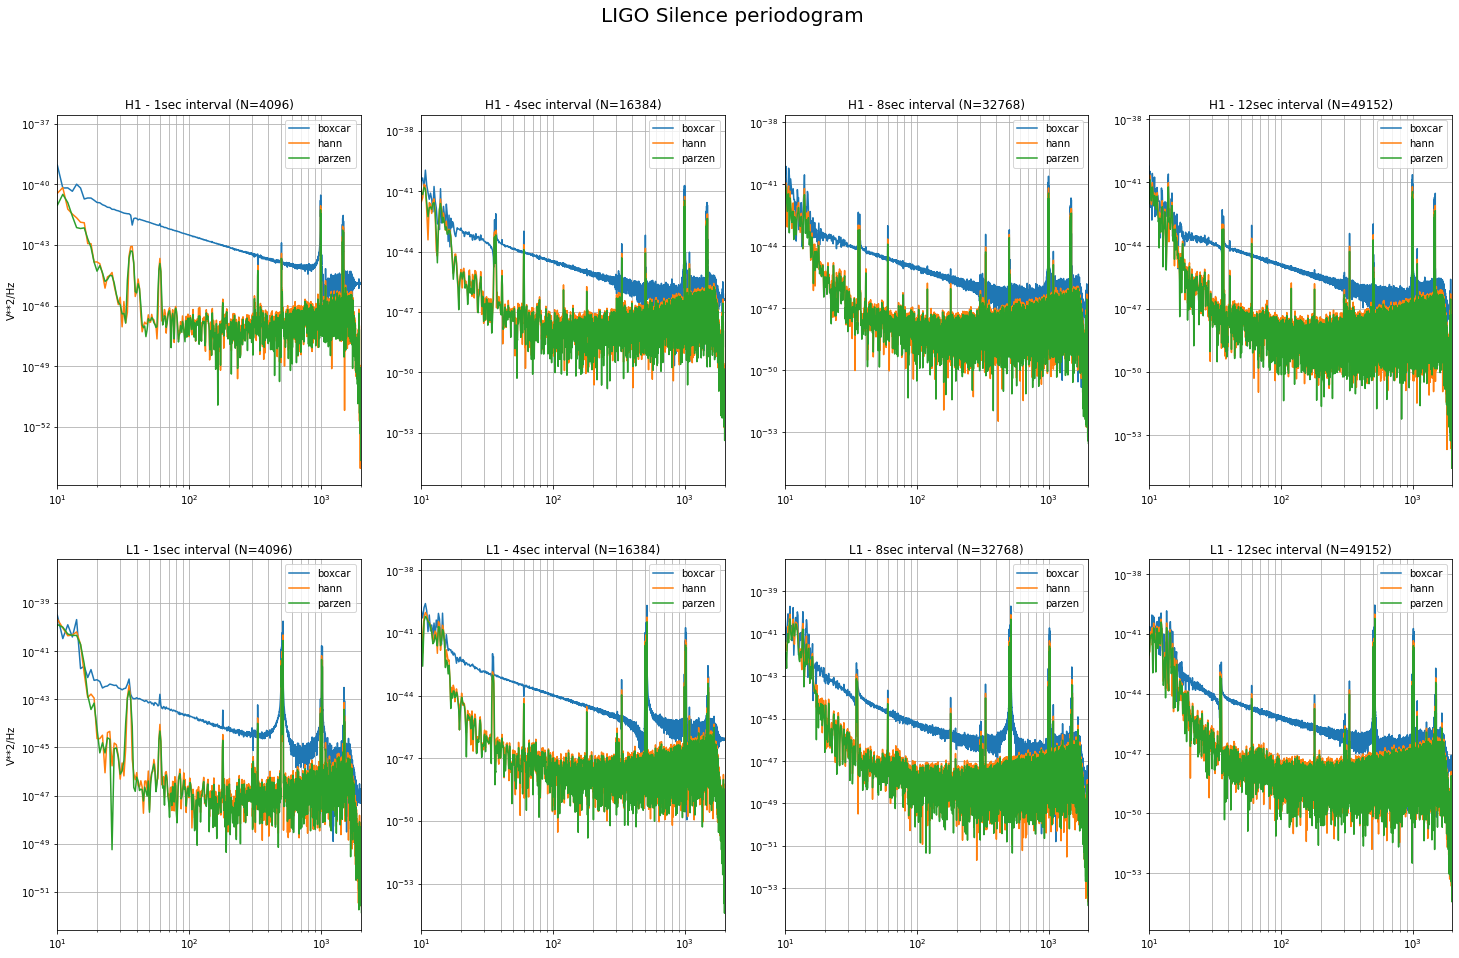

In [16]:
%%time
windows = ['boxcar', 'hann', 'parzen']
samples = [1,4,8,12]
signals = [h1_silence, l1_silence]

fig, axs = plt.subplots(2, 4, figsize=(25,15))
fig.suptitle('LIGO Silence periodogram', fontsize=20)
axs[0][0].set_ylabel('V**2/Hz')
axs[1][0].set_ylabel('V**2/Hz')
for i, s in enumerate(signals):
    for j,sample in enumerate(samples):
        for w in windows:
            plot_periodogram(axs[i][j], h1_fs, s[:int(sample*h1_fs)], w)
        tag = 'H1' if i == 0 else 'L1'
        axs[i][j].set_title(f'{tag} - {sample}sec interval (N={int(sample*h1_fs)})')
        axs[i][j].legend()
        axs[i][j].set_xlim(10,2000)  

## Periodogram averaging

In [17]:
def plot_periodogram_avg(ax, fs, signal, k, overlap):
    D = int(signal.shape[0] / k)
    L = int(D / (1-overlap))
    f, per = periodogram_averaging(signal, k, L)
    f *= fs
    ax.loglog(f,per, label=f'{o*100}% overlap')
    ax.grid(axis='both', which='both')

Wall time: 462 ms


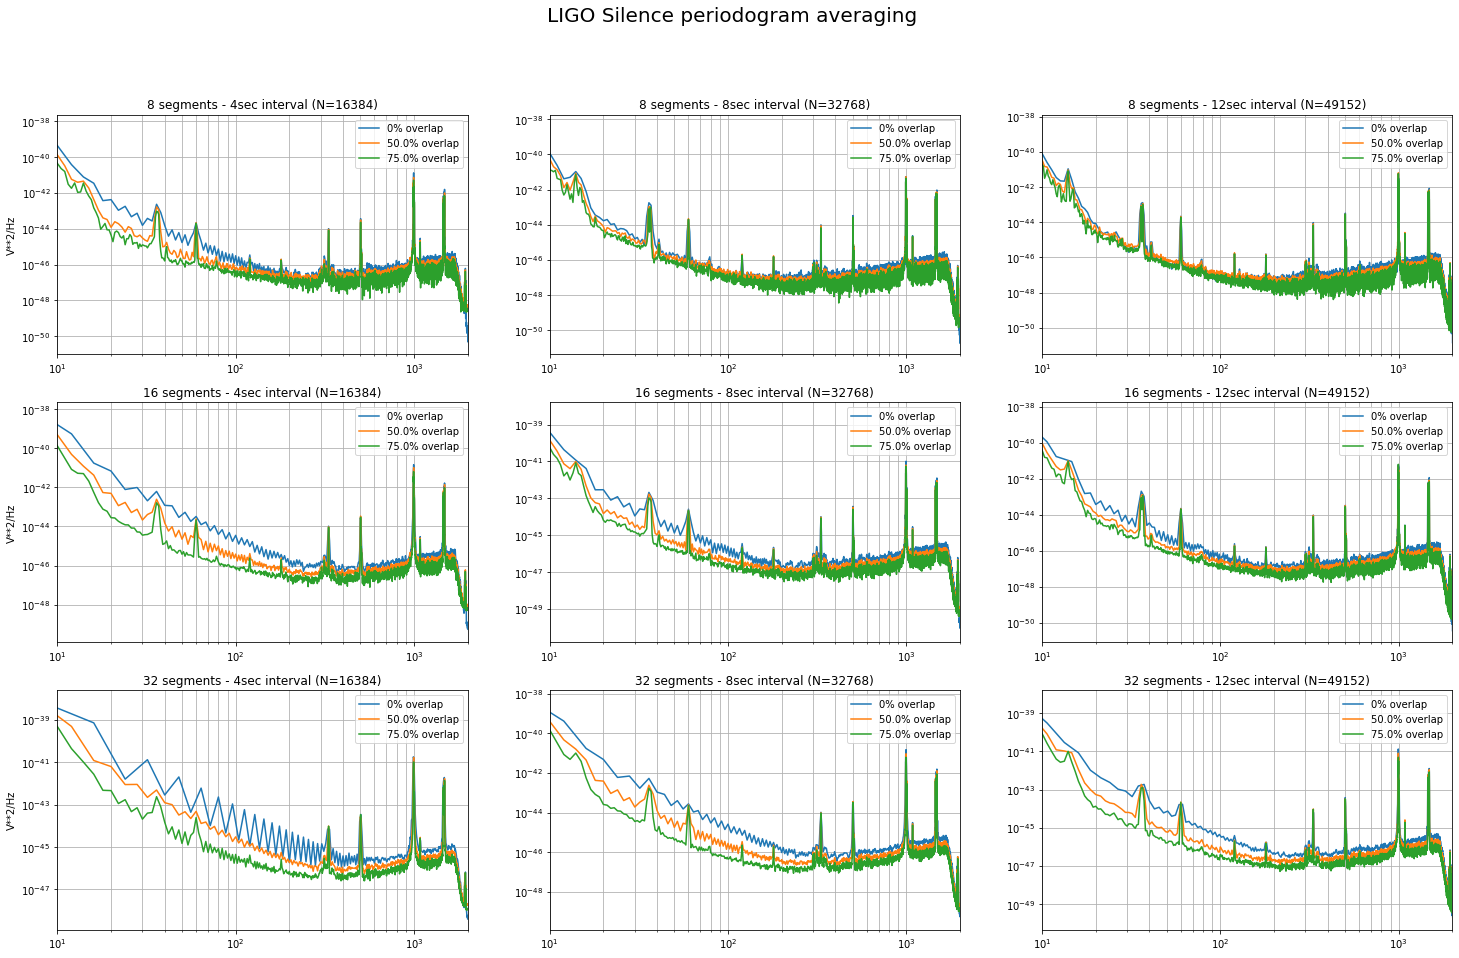

In [18]:
%%time
segments = [8, 16, 32]
samples = [4,8,12]
overlaps = [0,0.5, 0.75]

fig, axs = plt.subplots(3, 3, figsize=(25,15), tight_layout=False)
fig.suptitle('LIGO Silence periodogram averaging', fontsize=20)
axs[0][0].set_ylabel('V**2/Hz')
axs[1][0].set_ylabel('V**2/Hz')
axs[2][0].set_ylabel('V**2/Hz')

for i, k in enumerate(segments):
    for j,sample in enumerate(samples):
        for o in overlaps:
            plot_periodogram_avg(axs[i][j], h1_fs, h1_silence[:int(sample*h1_fs)], k, o)
        axs[i][j].set_title(f'{k} segments - {sample}sec interval (N={int(sample*h1_fs)})')
        axs[i][j].legend()
        axs[i][j].set_xlim(10,2000)        

## Periodogram smoothing

In [19]:
def plot_periodogram_smoothing(ax, fs, signal, L, window):
    f, per = periodogram_smoothing(signal, L, window=window, M=50)
    f *= fs
    ax.loglog(f,per, label=window)
    ax.grid(axis='both', which='both')

Wall time: 25.1 s


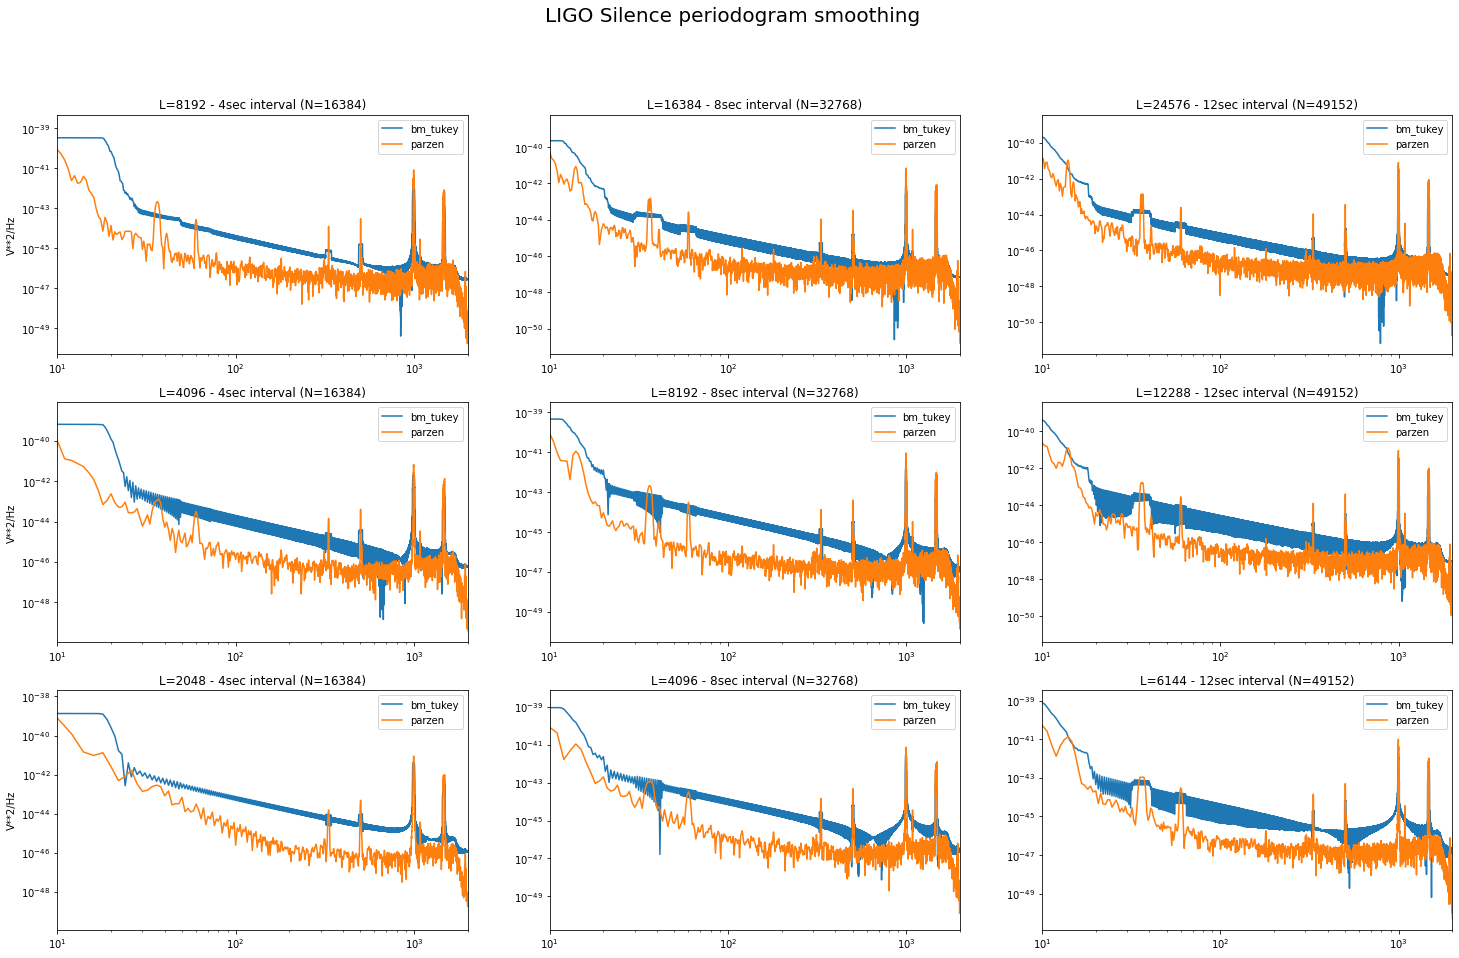

In [20]:
%%time
lengths = [2, 4, 8]
samples = [4,8,12] # seconds
windows = ['bm_tukey', 'parzen']

fig, axs = plt.subplots(3, 3, figsize=(25,15))
fig.suptitle('LIGO Silence periodogram smoothing', fontsize=20)
axs[0][0].set_ylabel('V**2/Hz')
axs[1][0].set_ylabel('V**2/Hz')
axs[2][0].set_ylabel('V**2/Hz')

for i, L in enumerate(lengths):
    for j,sample in enumerate(samples):
        for w in windows:
            plot_periodogram_smoothing(axs[i][j], h1_fs, h1_silence[:int(sample*h1_fs)], int(sample*h1_fs/L), w)
        axs[i][j].set_title(f'L={int(sample*h1_fs/L)} - {sample}sec interval (N={int(sample*h1_fs)})')
        axs[i][j].legend()
        axs[i][j].set_xlim(10,2000)

## Best psd estimation

In [21]:
%%time
# Best periodogram parameters
N = int(4*h1_fs)
window = 'parzen'

h1_per_f, h1_per_best = periodogram(h1_silence[:N], window=window)
l1_per_f, l1_per_best = periodogram(l1_silence[:N], window=window)

Wall time: 4.99 ms


In [22]:
%%time
# Best PA model parameters
k = 16              # 16 Segments
N = int(12*h1_fs)    # 12 secs
overlap = 0.5  #0.5

D = N // k
L = int(D / (1-overlap))
h1_pa_f, h1_pa_best = periodogram_averaging(h1_silence[:N], k, L)
l1_pa_f, l1_pa_best = periodogram_averaging(l1_silence[:N], k, L)

Wall time: 12 ms


In [23]:
%%time
# Best PS model parameters
N = int(12*h1_fs)
L = int(N/4) # N/4
window = 'parzen'

h1_ps_f, h1_ps_best = periodogram_smoothing(h1_silence[:N], L, window=window)
l1_ps_f, l1_ps_best = periodogram_smoothing(l1_silence[:N], L, window=window)

Wall time: 5.09 s


Wall time: 97.3 ms


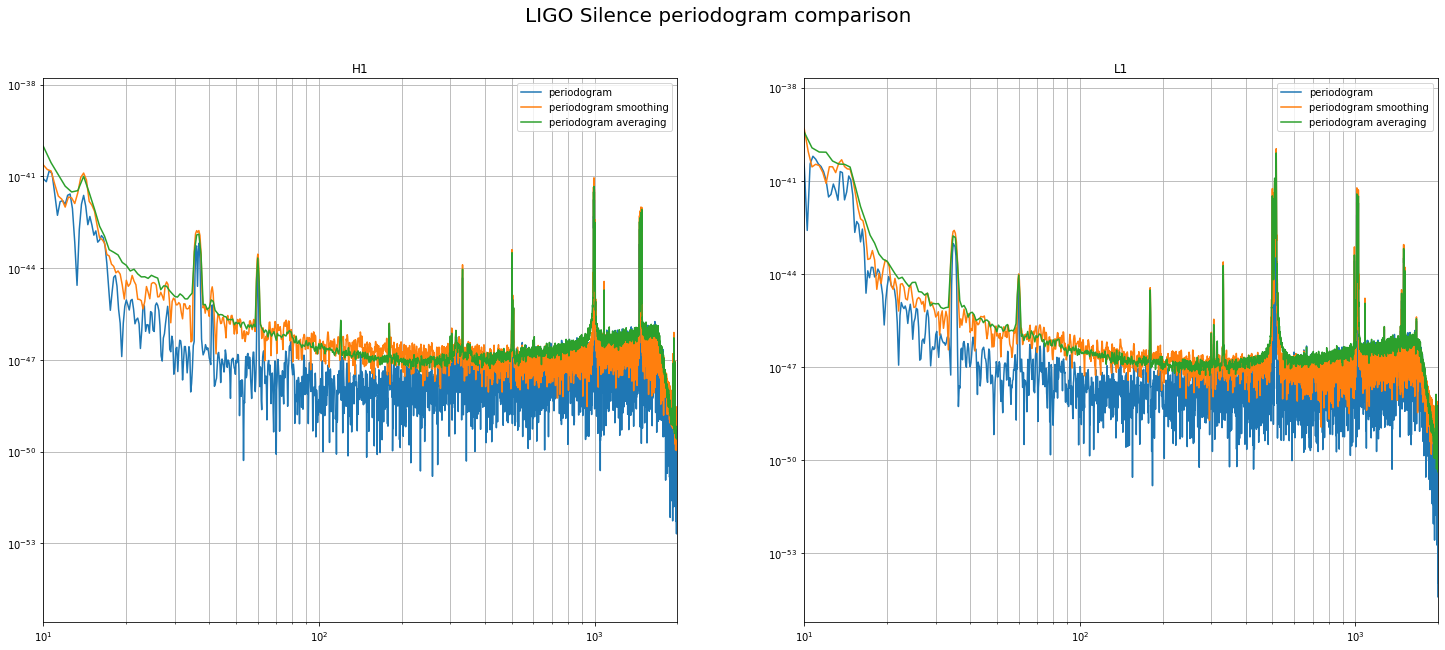

In [24]:
%%time
fig, axs = plt.subplots(1,2, figsize=(25,10))
fig.suptitle('LIGO Silence periodogram comparison', fontsize=20)

# Plotting H1
axs[0].loglog(h1_per_f*h1_fs, h1_per_best, label='periodogram')
axs[0].loglog(h1_ps_f*h1_fs, h1_ps_best, label='periodogram smoothing')
axs[0].loglog(h1_pa_f*h1_fs, h1_pa_best, label='periodogram averaging')

axs[0].set_xlim(10,2000)
axs[0].grid(axis='both', which='both')
axs[0].set_title('H1')
axs[0].legend()

# Plotting L1
axs[1].loglog(l1_per_f*l1_fs, l1_per_best, label='periodogram')
axs[1].loglog(l1_ps_f*l1_fs, l1_ps_best, label='periodogram smoothing')
axs[1].loglog(l1_pa_f*l1_fs, l1_pa_best, label='periodogram averaging')

axs[1].set_xlim(10,2000)
axs[1].grid(axis='both', which='both')
axs[1].set_title('L1')
axs[1].legend()

In [25]:
%%time
from helpers.whitenning import whiten, band_pass_filter
from scipy.interpolate import interp1d

# Generate interpolated spectrum
h1_interp_psd = interp1d(h1_pa_f*h1_fs, h1_pa_best, kind='nearest', bounds_error=False, assume_sorted=True)
l1_interp_psd = interp1d(l1_pa_f*l1_fs, l1_pa_best, kind='nearest', bounds_error=False, assume_sorted=True)

# Signal whitening
h1_whitened_signal = whiten(h1_s, h1_interp_psd, 1/h1_fs)
l1_whitened_signal = whiten(l1_s, l1_interp_psd, 1/l1_fs)


# Passband filter
h1_filtered_whitened_signal = band_pass_filter(h1_whitened_signal, h1_fs, [37,335]) # 20, 400 pero es mejor 35,350 ,37,335
l1_filtered_whitened_signal = band_pass_filter(l1_whitened_signal, l1_fs, [37,335])

Wall time: 57.9 ms


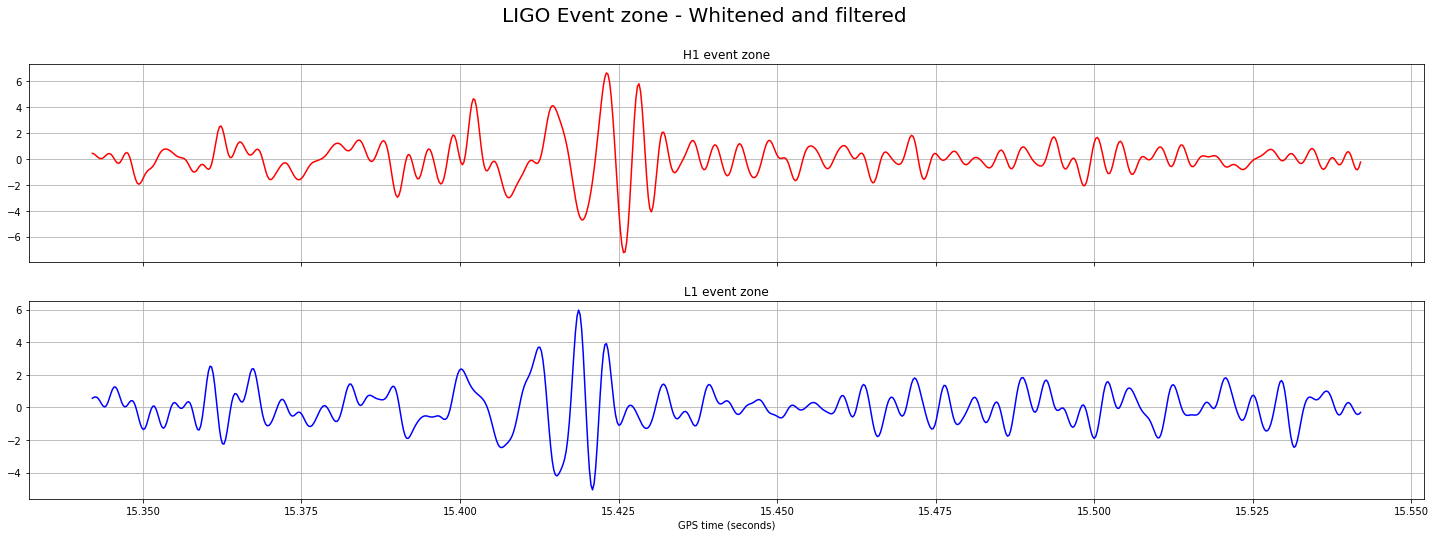

In [26]:
# Plot H1 and L1 signals
interval = (time > event_start-0.1) & (time < event_start+0.1)

fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Event zone - Whitened and filtered',fontsize=20)
axs[0].plot(time[interval], h1_filtered_whitened_signal[interval], color='red')
axs[1].plot(time[interval], l1_filtered_whitened_signal[interval], color='blue')
axs[0].set_title('H1 event zone')
axs[1].set_title('L1 event zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

In [27]:
import scipy.io.wavfile
wav_interval = (time > event_start - 2) & (time < event_start + 2)
# Scale signal to fit WAV format
h1_event_scaled = np.int16(h1_filtered_whitened_signal[wav_interval]/np.max(np.abs(h1_filtered_whitened_signal[wav_interval])) * 32767 * 0.9)
l1_event_scaled = np.int16(l1_filtered_whitened_signal[wav_interval]/np.max(np.abs(l1_filtered_whitened_signal[wav_interval])) * 32767 * 0.9)

# Save WAV files
scipy.io.wavfile.write('./output/h1_event.wav', int(h1_fs), h1_event_scaled)
scipy.io.wavfile.write('./output/l1_event.wav', int(l1_fs), l1_event_scaled)

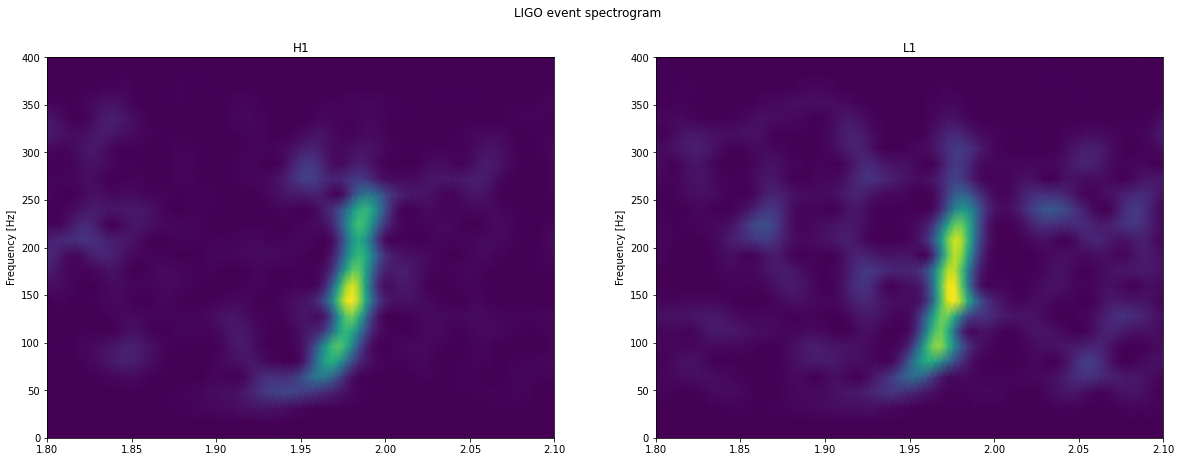

In [28]:
h1_f, h1_t, h1_sxx = sps.spectrogram(h1_event_scaled, h1_fs, window='blackman', nperseg=256, noverlap=240)
l1_f, l1_t, l1_sxx = sps.spectrogram(l1_event_scaled, l1_fs, window='blackman', nperseg=256, noverlap=240)

fig, axs = plt.subplots(1,2, figsize=(20,7))
fig.suptitle('LIGO event spectrogram')

# Plot H1 spectrogram
axs[0].pcolormesh(h1_t, h1_f, h1_sxx, shading='gouraud')
axs[0].set_ylabel('Frequency [Hz]')
axs[0].set_label('Time [sec]')
axs[0].set_ylim(0,400)
axs[0].set_xlim(1.8,2.1)
axs[0].set_title('H1')

# Plot L1 spectrogram
axs[1].pcolormesh(l1_t, l1_f, l1_sxx, shading='gouraud')
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_label('Time [sec]')
axs[1].set_ylim(0,400)
axs[1].set_xlim(1.8,2.1)
axs[1].set_title('L1');

## Cross correlation

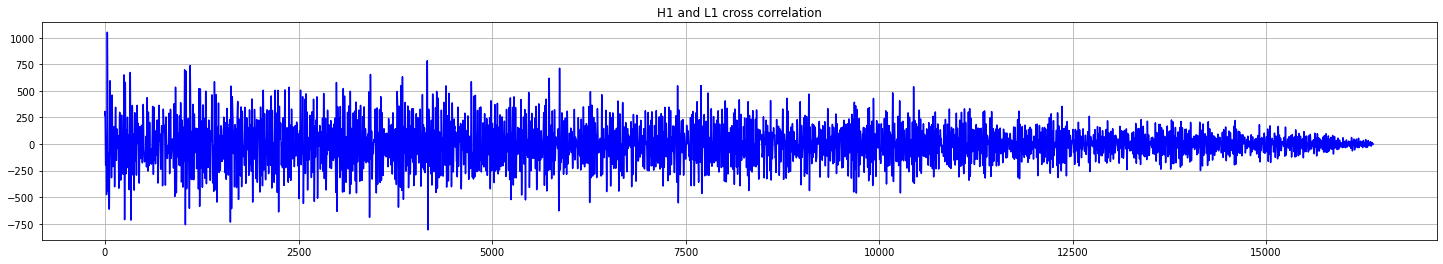

delta time is 7.080 ms


In [33]:
N = len(h1_filtered_whitened_signal[wav_interval])
x_corr = np.correlate(h1_filtered_whitened_signal[wav_interval], -l1_filtered_whitened_signal[wav_interval], 'full')
plt.figure(figsize=(25,4))
taps = np.arange(0, x_corr.shape[0], 1) - N + 1
plt.plot(x_corr[taps >= 0], color='blue')
plt.title('H1 and L1 cross correlation')
plt.grid()
plt.show()
print(f'delta time is {( (np.argmax(x_corr)-N)/h1_fs) * 1e3:.3f} ms')

In [34]:
filename = 'h1_event'
print(filename + '.wav')
Audio('./output/' + filename + '.wav')

h1_event.wav


In [35]:
filename = 'l1_event'
print(filename + '.wav')
Audio('./output/' + filename + '.wav')

l1_event.wav


In [36]:
def frec_shifter(data,fshift=100,sample_rate=4096):
    """Frequency shift the signal by constant
    """
    x = np.fft.rfft(data)
    T = len(data)/float(sample_rate)
    df = 1.0/T
    nbins = int(fshift/df)
    y = np.roll(x.real,nbins) + 1j*np.roll(x.imag,nbins)
    y[0:nbins]=0.
    z = np.fft.irfft(y)
    return z


In [40]:
fshift = 400.
strain_H1_shifted = frec_shifter(h1_filtered_whitened_signal, fshift=fshift, sample_rate=h1_fs)
strain_L1_shifted = frec_shifter(l1_filtered_whitened_signal, fshift=fshift, sample_rate=h1_fs)

In [38]:
h1_event_scaled_shifted = np.int16(strain_H1_shifted[wav_interval]/np.max(np.abs(strain_H1_shifted[wav_interval])) * 32767 * 0.9)
scipy.io.wavfile.write('./output/h1_event_shifted.wav', int(h1_fs), h1_event_scaled_shifted)


In [39]:
filename = 'h1_event_shifted'
print(filename + '.wav')
Audio('./output/' + filename + '.wav')

h1_event_shifted.wav


In [44]:
l1_event_scaled_shifted = np.int16(strain_L1_shifted[wav_interval]/np.max(np.abs(strain_L1_shifted[wav_interval])) * 32767 * 0.9)
scipy.io.wavfile.write('./output/h1_event_shifted.wav', int(h1_fs), l1_event_scaled_shifted)

In [45]:
filename = 'l1_event_shifted'
print(filename + '.wav')
Audio('./output/' + filename + '.wav')

l1_event_shifted.wav


ValueError: rate must be specified when data is a numpy array or list of audio samples.

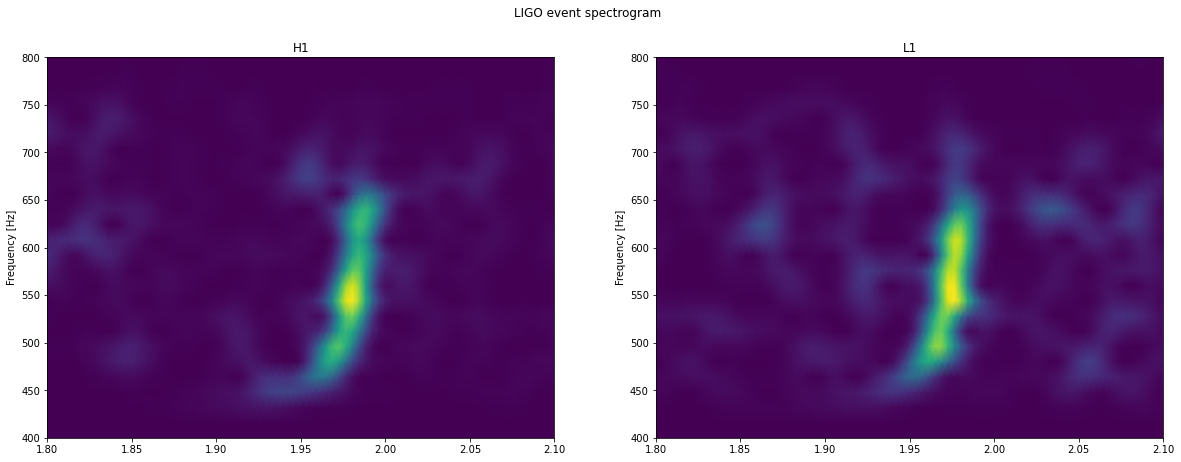

In [43]:
h1_f, h1_t, h1_sxx = sps.spectrogram(strain_H1_shifted[wav_interval], h1_fs, window='blackman', nperseg=256, noverlap=240)
l1_f, l1_t, l1_sxx = sps.spectrogram(strain_L1_shifted[wav_interval], l1_fs, window='blackman', nperseg=256, noverlap=240)

fig, axs = plt.subplots(1,2, figsize=(20,7))
fig.suptitle('LIGO event spectrogram')

# Plot H1 spectrogram
axs[0].pcolormesh(h1_t, h1_f, h1_sxx, shading='gouraud')
axs[0].set_ylabel('Frequency [Hz]')
axs[0].set_label('Time [sec]')
axs[0].set_ylim(400,800)
axs[0].set_xlim(1.8,2.1)
axs[0].set_title('H1')

# Plot L1 spectrogram
axs[1].pcolormesh(l1_t, l1_f, l1_sxx, shading='gouraud')
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_label('Time [sec]')
axs[1].set_ylim(400,800)
axs[1].set_xlim(1.8,2.1)
axs[1].set_title('L1');